This is my solution to a kaggle.com exercise, which I am writing to learn about machine learning.

Copyright (C) 2022 Chris March <https://github.com/chrismarch>

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

## Setup and Load

In [138]:
import os
import pandas as pd
import numpy as np

def load_csv_as_pd(csv_filename, data_path="."):
    csv_path = os.path.join(data_path, csv_filename)
    return pd.read_csv(csv_path)

train = load_csv_as_pd("train.csv")
y_train = train["Survived"].copy()

print(y_train)
train.iloc[0]

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                               22.0
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object

## Correlation

In [247]:
drop_attribs_cor = ["PassengerId", "Cabin"] # FIXME parse
X_cor = train.drop(drop_attribs_cor, axis=1)
print(list(X_cor))
num_attribs_cor = ['Survived', 'Pclass', "Ticket", 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs_cor = ['Sex', "Name", 'Embarked']


['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']


In [255]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import re

class RegExTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, col_idxs_to_regexes=[]): # no *args or **kargs
        self.col_idxs_to_regexes = col_idxs_to_regexes
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, Xdf):
        '''
        result = Xdf.values

        for col_idx_and_regex in self.col_idxs_to_regexes:
            col_idx = col_idx_and_regex[0]
            regex = col_idx_and_regex[1]
            r = regex
            #print(X)
            #print(result[:,col_idx])
            #print(result[0][col_idx])
            #print(r.search(result[0][col_idx]).group(0))
            new_result = []
            for row in result:
                title = r.search(str(row[col_idx]))
                title = title.group(0) if title else row[col_idx]
                new_result.append(title)
            #print(new_result)
            result[:, col_idx] = new_result
            #result[:, col_idx] = np.array([r.search(xi[col_idx]).group(0) for xi in result])
        '''
        result = Xdf.copy()
        for col_idx_and_regex in self.col_idxs_to_regexes:
            col_idx = col_idx_and_regex[0]
            regex = col_idx_and_regex[1]
            r = regex
            #print(X)
            #print(result[:,col_idx])
            #print(result[0][col_idx])
            #print(r.search(result[0][col_idx]).group(0))
            new_result = []
            for row in result[col_idx]:
                title = r.search(str(row))
                title = title.group(0) if title else None
                new_result.append(title)
            #print(new_result)
            result[col_idx] = new_result
            #result[:, col_idx] = np.array([r.search(xi[col_idx]).group(0) for xi in result])
        '''
        X_copy = X.copy()
        for col_idx_and_regex in self.col_idxs_to_regexes:
            col_idx = col_idx_and_regex[0]
            regex = col_idx_and_regex[1]
            r = regex
            X_copy[col_idx] = X_copy[col_idx].apply(lambda x: x if x in self.d[col] else 'CategoryGrouperOther')
        return X_copy
    
            X_copy = X.copy()
        for col in X_copy.columns:
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.d[col] else 'CategoryGrouperOther')
        return X_copy
        '''
        return result
                    
rc_name = re.compile(r"[\w]+(?=\.)")
rc_ticket = re.compile(r"(\d+)(?!.*\d)")
re_cat_tr = RegExTransformer(col_idxs_to_regexes=[("Name", rc_name)])
re_num_tr = RegExTransformer(col_idxs_to_regexes=[("Ticket", rc_ticket)])

X_re = re_cat_tr.transform(X_cor)
print(X_re)

     Survived  Pclass  Name     Sex   Age  SibSp  Parch            Ticket  \
0           0       3    Mr    male  22.0      1      0         A/5 21171   
1           1       1   Mrs  female  38.0      1      0          PC 17599   
2           1       3  Miss  female  26.0      0      0  STON/O2. 3101282   
3           1       1   Mrs  female  35.0      1      0            113803   
4           0       3    Mr    male  35.0      0      0            373450   
..        ...     ...   ...     ...   ...    ...    ...               ...   
886         0       2   Rev    male  27.0      0      0            211536   
887         1       1  Miss  female  19.0      0      0            112053   
888         0       3  Miss  female   NaN      1      2        W./C. 6607   
889         1       1    Mr    male  26.0      0      0            111369   
890         0       3    Mr    male  32.0      0      0            370376   

        Fare Embarked  
0     7.2500        S  
1    71.2833        C  
2  

In [256]:
num_pipe_cor = Pipeline([
        ('regex', re_num_tr),
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipe_cor = Pipeline([    
        ('regex', re_cat_tr),
        ('one', OneHotEncoder()),
    ])

col_trans_cor = ColumnTransformer([
        ("num", num_pipe_cor, num_attribs_cor),
        ("cat", cat_pipe_cor, cat_attribs_cor),
    ])

col_trans_cor.fit(X_cor, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('regex',
                                                  RegExTransformer(col_idxs_to_regexes=[('Ticket',
                                                                                         re.compile('(\\d+)(?!.*\\d)'))])),
                                                 ('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Survived', 'Pclass', 'Ticket', 'Age',
                                  'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('regex',
                                                  RegExTransformer(col_idxs_to_regexes=[('Name',
                                                                                         re.compile('[\\w]+(?=\\.)'))])),
           

In [257]:
#trcp = train.copy()
#corr_matrix = trcp.corr()
#print(corr_matrix["Survived"].sort_values(ascending=False))

#print(trcp.iloc[0])
trtr = col_trans_cor.transform(trcp)
#print(main_pipeline.named_steps['col'].transformers_[0][1].get_feature_names_out())
print(col_trans_cor.transformers_[1][1].named_steps['one'].get_feature_names_out())
onehot_attribs_cor = col_trans_cor.transformers_[1][1].named_steps['one'].get_feature_names_out()
#print(col_trans.named_steps["cat"].get_feature_names_out())

print(trtr[0])
all_attribs = list(trcp)
#print(all_attribs)
print(num_attribs_cor)
print(onehot_attribs_cor)
tr_attribs = list(num_attribs_cor) + list(onehot_attribs_cor)
trc = pd.DataFrame(trtr, columns=tr_attribs)
#print(trc.iloc[0])
cor_matrix = trc.corr()
print(cor_matrix["Survived"].sort_values(ascending=False))
cor_matrix

['Sex_female' 'Sex_male' 'Name_Capt' 'Name_Col' 'Name_Countess' 'Name_Don'
 'Name_Dr' 'Name_Jonkheer' 'Name_Lady' 'Name_Major' 'Name_Master'
 'Name_Miss' 'Name_Mlle' 'Name_Mme' 'Name_Mr' 'Name_Mrs' 'Name_Ms'
 'Name_Rev' 'Name_Sir' 'Embarked_C' 'Embarked_Q' 'Embarked_S'
 'Embarked_nan']
[-0.78927234  0.82737724 -0.42264642 -0.5924806   0.43279337 -0.47367361
 -0.50244517  0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.        ]
['Survived', 'Pclass', 'Ticket', 'Age', 'SibSp', 'Parch', 'Fare']
['Sex_female' 'Sex_male' 'Name_Capt' 'Name_Col' 'Name_Countess' 'Name_Don'
 'Name_Dr' 'Name_Jonkheer' 'Name_Lady' 'Name_Major' 'Name_Master'
 'Name_Miss' 'Name_Mlle' 'Name_Mme' 'Name_Mr' 'Name_Mrs' 'Name_Ms'
 'Name_Rev' 'Name_Sir' 'Embarked_C' 'Embarked_Q' 'Embarked_S'
 'Embarked_nan']
Survived         1

,Survived,Pclass,Ticket,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Name_Capt,...,Name_Mme,Name_Mr,Name_Mrs,Name_Ms,Name_Rev,Name_Sir,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
Survived,1.000000,-0.338481,-0.096212,-0.069809,-0.035322,0.081629,0.257307,0.543351,-0.543351,-0.026456,...,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,0.168240,0.003650,-0.155660,0.060095
Pclass,-0.338481,1.000000,0.285837,-0.331339,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.052496,...,-0.052496,0.142698,-0.149209,-0.012381,-0.030413,-0.052496,-0.243292,0.221009,0.081720,-0.074282
Ticket,-0.096212,0.285837,1.000000,-0.103663,0.045995,-0.033512,-0.156767,-0.077235,0.077235,-0.014956,...,-0.014356,0.075494,-0.065352,-0.003470,-0.012984,-0.014356,-0.194506,-0.003486,0.173568,-0.013363
Age,-0.069809,-0.331339,-0.103663,1.000000,-0.232625,-0.179191,0.091566,-0.084153,0.084153,0.103957,...,-0.014701,0.185900,0.166499,-0.004383,0.085335,0.049787,0.032024,-0.013855,-0.027121,0.074099
SibSp,-0.035322,0.083081,0.045995,-0.232625,1.000000,0.414838,0.159651,0.114631,-0.114631,0.014507,...,-0.015907,-0.250489,0.063407,-0.015907,-0.026622,0.014507,-0.059528,-0.026354,0.070941,-0.022508
Parch,0.081629,0.018443,-0.033512,-0.179191,0.414838,1.000000,0.216225,0.245489,-0.245489,0.025731,...,-0.015878,-0.333905,0.225852,-0.015878,-0.021967,-0.015878,-0.011069,-0.081228,0.063036,-0.022467
Fare,0.257307,-0.549500,-0.156767,0.091566,0.159651,0.216225,1.000000,0.182333,-0.182333,0.026184,...,0.025037,-0.183766,0.105203,-0.012961,-0.023031,0.016687,0.269335,-0.117216,-0.166603,0.045646
Sex_female,0.543351,-0.131900,-0.077235,-0.084153,0.114631,0.245489,0.182333,1.000000,-1.000000,-0.024728,...,0.045439,-0.867334,0.547600,0.045439,-0.060741,-0.024728,0.082853,0.074115,-0.125722,0.064296
Sex_male,-0.543351,0.131900,0.077235,0.084153,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,0.024728,...,-0.045439,0.867334,-0.547600,-0.045439,0.060741,0.024728,-0.082853,-0.074115,0.125722,-0.064296
Name_Capt,-0.026456,-0.052496,-0.014956,0.103957,0.014507,0.025731,0.026184,-0.024728,0.024728,1.000000,...,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.016158,-0.010310,0.020759,-0.001590


## Training
### Pipeline

In [240]:
drop_attribs = ["Survived", "PassengerId", "Name", "Ticket", "Cabin"] # FIXME parse
drop_attribs = ['Survived', 'PassengerId', 'Name',  'SibSp','Age', 'Fare', 'Embarked',"Ticket", "Cabin"]
print(list(X_train))
X_train = train.drop(drop_attribs, axis=1)
print(list(X_train))
#cat_attribs = {"Sex", "Embarked"}
cat_attribs = {"Sex"}
num_attribs = list(set(X_train) - cat_attribs)
cat_attribs = list(cat_attribs)
num_attribs

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
['Pclass', 'Sex', 'Parch']


['Parch', 'Pclass']

In [241]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

col_trans = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

param_grid = [
    {'n_estimators': [3, 10, 30, 100], 'max_features': ["auto", "sqrt", "log2"]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 100], 'max_features': ["auto", "sqrt", "log2"]},
  ]

grid_search = GridSearchCV(forest_class, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=1)

#col_trans.named_transformers_["cat"].handle_unknown = 'ignore'

main_pipeline = Pipeline([
    ('col', col_trans),
#    ('dropper', AttributesDropper()),
    ('forest', RandomForestClassifier(random_state=42))
#     ('knn', KNeighborsClassifier(random_state=42))    
#         ('sgd', SGDClassifier(random_state=42))    
#    ('grid', grid_search)
])

pipe_out = main_pipeline.fit(X_train, y_train)

## Training
### Scoring

In [242]:
y_train_predict = cross_val_predict(pipe_out, X_train, y_train, cv=3)
#print(y_train)
#print(y_train_predict)
f1_score(y_train, y_train_predict, average="macro")

# forest
# 0.7799527542145388 no grid
# 0.7799498232748209 grid cv=3
# 0.7697534246575342 grid cv=5

# knn
# 0.7716740397065172 no grid

# sgd
# 0.7527507166411622

0.7745977880614578

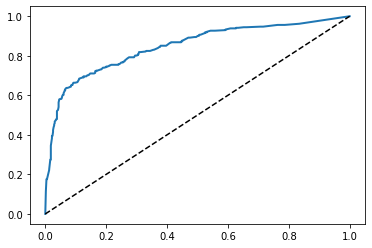

0.8464512830345443

In [61]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_scores = cross_val_predict(pipe_out, X_train, y_train, cv=3,
                             method="predict_proba")
                             #method="decision_function") #SGD
    
y_scores = y_scores[:, 1]   # score = proba of positive class

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()
roc_auc_score(y_train, y_scores)

# forest
# 0.8464512830345443 no grid
# 0.8433195922410763 grid

# knn
# 0.8310165212667369

# sgd
# 0.8110147104251216